# Ford Fiesta Price Dataset: Exploratory Data Analysis

**Author:** Jeffery Lane  
**Date:** November 2025

## Project Overview

This notebook documents the exploratory data analysis (EDA) process for a dataset of used Ford Fiesta listings scraped from Cars.com. The goal is to understand the data characteristics, clean and prepare the data for modeling, and discover key insights about factors that influence Ford Fiesta pricing.

**Objectives:**
1. Load and examine the raw scraped data
2. Clean the data by handling missing values and invalid entries
3. Engineer features from raw text fields
4. Visualize distributions and relationships
5. Document key insights discovered during exploration

---
## 1. Import Libraries

In [41]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

---
## 2. Load and Examine Raw Data

The data was scraped from Cars.com using a search for used Ford Fiestas at any distance from Denver, CO. The raw data contains 4 columns scraped directly from the listings.

In [42]:
# Load the raw scraped data
df_raw = pd.read_csv('ford_fiestas_all.csv')

# Display basic info
print("=" * 60)
print("RAW DATASET OVERVIEW")
print("=" * 60)
print(f"\nShape: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns")
print(f"\nColumn names: {list(df_raw.columns)}")

RAW DATASET OVERVIEW

Shape: 697 rows × 4 columns

Column names: ['title', 'price', 'mileage', 'location']


In [43]:
# Preview the first few rows
print("\nFirst 10 rows of raw data:")
df_raw.head(10)


First 10 rows of raw data:


,title,price,mileage,location
0,2017 Ford Fiesta SE,"$6,990","64,372 mi.","Miami, FL (1,716 mi.)"
1,2019 Ford Fiesta SE,"$8,119","92,119 mi.","Springfield, MO (658 mi.)"
2,2015 Ford Fiesta SE,"$6,987","117,862 mi.","Muskegon, MI (998 mi.)"
3,2016 Ford Fiesta ST,"$10,989","100,423 mi.","Springfield, MO (658 mi.)"
4,2019 Ford Fiesta SE,"$8,435","71,117 mi.","North Richland Hills, TX (644 mi.)"
5,2016 Ford Fiesta SE,"$9,338","64,466 mi.","Perrysburg, OH (1,122 mi.)"
6,2019 Ford Fiesta ST Line,"$14,000","53,290 mi.","Kenosha, WI (909 mi.)"
7,2017 Ford Fiesta Titanium,"$9,995","82,703 mi.","Avon, MA (1,767 mi.)"
8,2016 Ford Fiesta S,"$6,998","92,625 mi.","Renfrew, PA (1,314 mi.)"
9,2019 Ford Fiesta SE,"$12,398","32,703 mi.","Lincoln, NE (443 mi.)"


In [44]:
# Data types and memory usage
print("\nData Types and Memory Usage:")
print(df_raw.info())


Data Types and Memory Usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     697 non-null    object
 1   price     697 non-null    object
 2   mileage   697 non-null    object
 3   location  697 non-null    object
dtypes: object(4)
memory usage: 21.9+ KB
None


### 2.1 Understanding the Raw Data Structure

Each column contains embedded information that needs to be extracted:

| Column | Raw Format | Embedded Info |
|--------|-----------|---------------|
| `title` | "2017 Ford Fiesta SE" | Year, Make, Model, Trim |
| `price` | "$6,990" | Numeric price (or "Not Priced") |
| `mileage` | "64,372 mi." | Numeric mileage |
| `location` | "Miami, FL (1,716 mi.)" | City, State, Distance from Denver |

In [45]:
# Check for unique values in each column
print("Unique Value Counts:")
print("=" * 40)
for col in df_raw.columns:
    print(f"{col}: {df_raw[col].nunique()} unique values")

Unique Value Counts:
title: 59 unique values
price: 362 unique values
mileage: 696 unique values
location: 549 unique values


---
## 3. Data Cleaning

### 3.1 Identify Data Quality Issues

The data scraping from cars.com led to all entries having complete data.

In [46]:
# Check for missing values
print("Missing Values:")
print("=" * 40)
print(df_raw.isnull().sum())
print(f"\nTotal missing: {df_raw.isnull().sum().sum()}")

Missing Values:
title       0
price       0
mileage     0
location    0
dtype: int64

Total missing: 0


In [47]:
# Check for "Not Priced" entries
not_priced_count = (df_raw['price'] == 'Not Priced').sum()
print(f"\nListings with 'Not Priced': {not_priced_count}")
print(f"Percentage of data: {not_priced_count / len(df_raw) * 100:.2f}%")

# Preview some Not Priced entries
print("\nSample 'Not Priced' listings:")
df_raw[df_raw['price'] == 'Not Priced'].head()


Listings with 'Not Priced': 25
Percentage of data: 3.59%

Sample 'Not Priced' listings:


,title,price,mileage,location
583,2016 Ford Fiesta SE,Not Priced,"79,466 mi.","El Paso, TX (557 mi.)"
584,2012 Ford Fiesta SES,Not Priced,"126,192 mi.","El Paso, TX (557 mi.)"
587,2016 Ford Fiesta S,Not Priced,"80,067 mi.","Peoria, AZ (585 mi.)"
596,2015 Ford Fiesta SE,Not Priced,"161,414 mi.","BROOKLYN CENTER, MN (697 mi.)"
601,2014 Ford Fiesta SE,Not Priced,"85,547 mi.","Bemidji, MN (734 mi.)"


In [48]:
# Check the unique price values (to see format)
print("\nSample price values:")
print(df_raw['price'].value_counts().head(15))


Sample price values:
price
Not Priced    25
$7,995        19
$6,995        17
$5,995        14
$6,999        12
$4,995        12
$9,995        12
$5,999        12
$8,995        11
$3,995        10
$4,999         9
$12,998        8
$9,999         7
$11,998        7
$5,500         7
Name: count, dtype: int64


### 3.2 Remove Unpriceable Listings

Non-priced listings got removed. I could have tried harder to imputate the prices, butttt i didnt feel like it so here we are.

In [49]:
# Remove "Not Priced" listings
df_clean = df_raw[df_raw['price'] != 'Not Priced'].copy()

print("Data Cleaning Results:")
print("=" * 40)
print(f"Original dataset size: {len(df_raw)} rows")
print(f"Cleaned dataset size:  {len(df_clean)} rows")
print(f"Rows removed:          {len(df_raw) - len(df_clean)} rows")

Data Cleaning Results:
Original dataset size: 697 rows
Cleaned dataset size:  672 rows
Rows removed:          25 rows


---
## 4. Feature Engineering

Extract structured features from the raw text fields. This process converts human-readable strings into numeric and categorical values suitable for analysis and modeling.

### 4.1 Extract Year and Trim from Title

In [50]:
# Extract year from title (first 4 characters)
df_clean['year'] = df_clean['title'].str[:4].astype(int)

# Extract trim level (everything after "Ford Fiesta ")
df_clean['trim'] = df_clean['title'].str.split('Ford Fiesta ').str[1]

# Preview the extraction
print("Year and Trim Extraction:")
df_clean[['title', 'year', 'trim']].head(10)

Year and Trim Extraction:


,title,year,trim
0,2017 Ford Fiesta SE,2017,SE
1,2019 Ford Fiesta SE,2019,SE
2,2015 Ford Fiesta SE,2015,SE
3,2016 Ford Fiesta ST,2016,ST
4,2019 Ford Fiesta SE,2019,SE
5,2016 Ford Fiesta SE,2016,SE
6,2019 Ford Fiesta ST Line,2019,ST Line
7,2017 Ford Fiesta Titanium,2017,Titanium
8,2016 Ford Fiesta S,2016,S
9,2019 Ford Fiesta SE,2019,SE


### 4.2 Consolidate Trim Levels

The raw trim data contains many variations of the same trim level (e.g., "SE 4dr Sedan", "SE Sedan", "SE Hatchback" are all just "SE"). These need to be consolidated into the 7 standard Ford Fiesta trim levels:

- **S** - Base model
- **SE** - Most common, mid-level trim
- **SEL** - SE Luxury package
- **SES** - SE Sport package
- **ST** - Performance/Sport variant
- **ST Line** - Sport appearance package
- **Titanium** - Top-tier luxury trim

In [51]:
# Check raw trim values before consolidation
print("Raw Trim Values (before consolidation):")
print("=" * 50)
print(df_clean['trim'].value_counts())
print(f"\nTotal unique trims: {df_clean['trim'].nunique()}")

Raw Trim Values (before consolidation):
trim
SE                    450
S                      87
ST                     65
Titanium               20
SE 4dr Sedan            9
ST Line                 8
SEL                     6
SES                     6
ST 4dr Hatchback        4
SE Sedan                4
S 4dr Sedan             3
SE Hatchback            2
SE 4dr Hatchback        2
5dr HB SE               1
4dr Sdn SE              1
TITANIUM                1
Titanium Hatchback      1
ST Hatch                1
SES 4dr Hatchback       1
Name: count, dtype: int64

Total unique trims: 19


In [52]:
# Define mapping to consolidate trim variations to standard trim levels
trim_mapping = {
    # SE variations
    'SE 4dr Sedan': 'SE',
    'SE Sedan': 'SE',
    'SE 4dr Hatchback': 'SE',
    'SE Hatchback': 'SE',
    '5dr HB SE': 'SE',
    '4dr Sdn SE': 'SE',
    
    # S variations
    'S 4dr Sedan': 'S',
    
    # ST variations
    'ST 4dr Hatchback': 'ST',
    'ST Hatch': 'ST',
    
    # SES variations
    'SES 4dr Hatchback': 'SES',
    
    # Titanium variations (case normalization)
    'TITANIUM': 'Titanium',
    'Titanium Hatchback': 'Titanium',
}

# Apply the mapping (keep original if not in mapping)
df_clean['trim'] = df_clean['trim'].replace(trim_mapping)

print("Trim Values After Consolidation:")
print("=" * 50)
print(df_clean['trim'].value_counts())
print(f"\nTotal unique trims: {df_clean['trim'].nunique()}")

Trim Values After Consolidation:
trim
SE          469
S            90
ST           70
Titanium     22
ST Line       8
SES           7
SEL           6
Name: count, dtype: int64

Total unique trims: 7


In [83]:
# Verify all trims are now in the expected set
expected_trims = {'S', 'SE', 'SEL', 'SES', 'ST', 'ST Line', 'Titanium'}
actual_trims = set(df_clean['trim'].unique())

if actual_trims == expected_trims:
    print("✅ All trims successfully consolidated to 7 standard levels")
else:
    unexpected = actual_trims - expected_trims
    if unexpected:
        print(f"⚠️ Unexpected trims found: {unexpected}")
    missing = expected_trims - actual_trims
    if missing:
        print(f"ℹ️ Expected trims not in data: {missing}")

✅ All trims successfully consolidated to 7 standard levels


### 4.3 Convert Price to Numeric

In [54]:
# Convert price: remove $ and commas, convert to integer
df_clean['price_numeric'] = (df_clean['price']
                              .str.replace('$', '', regex=False)
                              .str.replace(',', '', regex=False)
                              .astype(int))

# Preview
print("Price Conversion:")
df_clean[['price', 'price_numeric']].head(10)

Price Conversion:


,price,price_numeric
0,"$6,990",6990
1,"$8,119",8119
2,"$6,987",6987
3,"$10,989",10989
4,"$8,435",8435
5,"$9,338",9338
6,"$14,000",14000
7,"$9,995",9995
8,"$6,998",6998
9,"$12,398",12398


### 4.4 Convert Mileage to Numeric

In [55]:
# Convert mileage: remove commas and " mi.", convert to integer
df_clean['mileage_numeric'] = (df_clean['mileage']
                                .str.replace(',', '', regex=False)
                                .str.replace(' mi.', '', regex=False)
                                .astype(int))

# Preview
print("Mileage Conversion:")
df_clean[['mileage', 'mileage_numeric']].head(10)

Mileage Conversion:


,mileage,mileage_numeric
0,"64,372 mi.",64372
1,"92,119 mi.",92119
2,"117,862 mi.",117862
3,"100,423 mi.",100423
4,"71,117 mi.",71117
5,"64,466 mi.",64466
6,"53,290 mi.",53290
7,"82,703 mi.",82703
8,"92,625 mi.",92625
9,"32,703 mi.",32703


### 4.5 Extract State and Distance from Location

In [56]:
# Extract state (2-letter abbreviation after comma)
df_clean['state'] = df_clean['location'].str.split(', ').str[1].str[:2]

# Extract distance using regex pattern
df_clean['distance'] = (df_clean['location']
                         .str.extract(r'\(([0-9,]+) mi\.\)')[0]
                         .str.replace(',', '', regex=False)
                         .astype(int))

# Preview
print("Location Extraction:")
df_clean[['location', 'state', 'distance']].head(10)

Location Extraction:


,location,state,distance
0,"Miami, FL (1,716 mi.)",FL,1716
1,"Springfield, MO (658 mi.)",MO,658
2,"Muskegon, MI (998 mi.)",MI,998
3,"Springfield, MO (658 mi.)",MO,658
4,"North Richland Hills, TX (644 mi.)",TX,644
5,"Perrysburg, OH (1,122 mi.)",OH,1122
6,"Kenosha, WI (909 mi.)",WI,909
7,"Avon, MA (1,767 mi.)",MA,1767
8,"Renfrew, PA (1,314 mi.)",PA,1314
9,"Lincoln, NE (443 mi.)",NE,443


### 4.6 Create Final Processed Dataset

In [57]:
# Create the final processed dataframe with renamed columns
df = df_clean[['title', 'price_numeric', 'mileage_numeric', 'location', 
               'year', 'trim', 'state', 'distance']].copy()
df.columns = ['title', 'price', 'mileage', 'location', 
              'year', 'trim', 'state', 'distance']

print("Final Processed Dataset:")
print("=" * 60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
print("\nFirst 10 rows:")
df.head(10)

Final Processed Dataset:
Shape: 672 rows × 8 columns

Columns: ['title', 'price', 'mileage', 'location', 'year', 'trim', 'state', 'distance']

First 10 rows:


,title,price,mileage,location,year,trim,state,distance
0,2017 Ford Fiesta SE,6990,64372,"Miami, FL (1,716 mi.)",2017,SE,FL,1716
1,2019 Ford Fiesta SE,8119,92119,"Springfield, MO (658 mi.)",2019,SE,MO,658
2,2015 Ford Fiesta SE,6987,117862,"Muskegon, MI (998 mi.)",2015,SE,MI,998
3,2016 Ford Fiesta ST,10989,100423,"Springfield, MO (658 mi.)",2016,ST,MO,658
4,2019 Ford Fiesta SE,8435,71117,"North Richland Hills, TX (644 mi.)",2019,SE,TX,644
5,2016 Ford Fiesta SE,9338,64466,"Perrysburg, OH (1,122 mi.)",2016,SE,OH,1122
6,2019 Ford Fiesta ST Line,14000,53290,"Kenosha, WI (909 mi.)",2019,ST Line,WI,909
7,2017 Ford Fiesta Titanium,9995,82703,"Avon, MA (1,767 mi.)",2017,Titanium,MA,1767
8,2016 Ford Fiesta S,6998,92625,"Renfrew, PA (1,314 mi.)",2016,S,PA,1314
9,2019 Ford Fiesta SE,12398,32703,"Lincoln, NE (443 mi.)",2019,SE,NE,443


In [58]:
# Data types of processed dataset
print("\nProcessed Data Types:")
print(df.dtypes)


Processed Data Types:
title       object
price        int64
mileage      int64
location    object
year         int64
trim        object
state       object
distance     int64
dtype: object


---
## 5. Exploratory Data Analysis

### 5.1 Summary Statistics

In [59]:
# Summary statistics for numeric columns
print("Summary Statistics for Numeric Variables:")
print("=" * 60)
df[['price', 'mileage', 'year', 'distance']].describe()

Summary Statistics for Numeric Variables:


,price,mileage,year,distance
count,672.000000,672.000000,672.000000,672.000000
mean,8357.072917,87966.358631,2016.190476,1046.409226
std,3030.442225,35382.492312,2.376493,417.112519
min,499.000000,0.000000,2011.000000,6.000000
25%,5997.000000,63995.750000,2014.000000,769.250000
50%,7995.000000,84842.500000,2017.000000,1023.000000
75%,9999.000000,110487.250000,2019.000000,1446.500000
max,19999.000000,209211.000000,2019.000000,3342.000000


In [60]:
# Key insights from summary stats
print("\nKey Statistics:")
print("=" * 60)
print(f"Price Range:    ${df['price'].min():,} - ${df['price'].max():,}")
print(f"Mean Price:     ${df['price'].mean():,.2f}")
print(f"Median Price:   ${df['price'].median():,.2f}")
print(f"\nMileage Range:  {df['mileage'].min():,} - {df['mileage'].max():,} miles")
print(f"Mean Mileage:   {df['mileage'].mean():,.0f} miles")
print(f"\nYear Range:     {df['year'].min()} - {df['year'].max()}")
print(f"\nDistance Range: {df['distance'].min():,} - {df['distance'].max():,} miles from Denver")


Key Statistics:
Price Range:    $499 - $19,999
Mean Price:     $8,357.07
Median Price:   $7,995.00

Mileage Range:  0 - 209,211 miles
Mean Mileage:   87,966 miles

Year Range:     2011 - 2019

Distance Range: 6 - 3,342 miles from Denver


### 5.2 Categorical Variable Analysis

In [61]:
# Trim level distribution
print("Trim Level Distribution:")
print("=" * 40)
trim_counts = df['trim'].value_counts()
print(trim_counts)
print(f"\nTotal unique trims: {df['trim'].nunique()}")

Trim Level Distribution:
trim
SE          469
S            90
ST           70
Titanium     22
ST Line       8
SES           7
SEL           6
Name: count, dtype: int64

Total unique trims: 7


In [62]:
# State distribution (top 15)
print("\nState Distribution (Top 15):")
print("=" * 40)
state_counts = df['state'].value_counts()
print(state_counts.head(15))
print(f"\nTotal unique states: {df['state'].nunique()}")


State Distribution (Top 15):
state
FL    57
TX    47
VA    43
OH    41
CA    41
IL    36
IN    28
NC    28
MO    24
AZ    23
MI    22
IA    22
WA    21
PA    21
CO    20
Name: count, dtype: int64

Total unique states: 44


In [63]:
# Year distribution
print("\nYear Distribution:")
print("=" * 40)
year_counts = df['year'].value_counts().sort_index()
print(year_counts)


Year Distribution:
year
2011     26
2012     27
2013     54
2014     62
2015     94
2016     72
2017     98
2018     69
2019    170
Name: count, dtype: int64


---
## 6. Visualizations

### 6.1 Distribution Plots

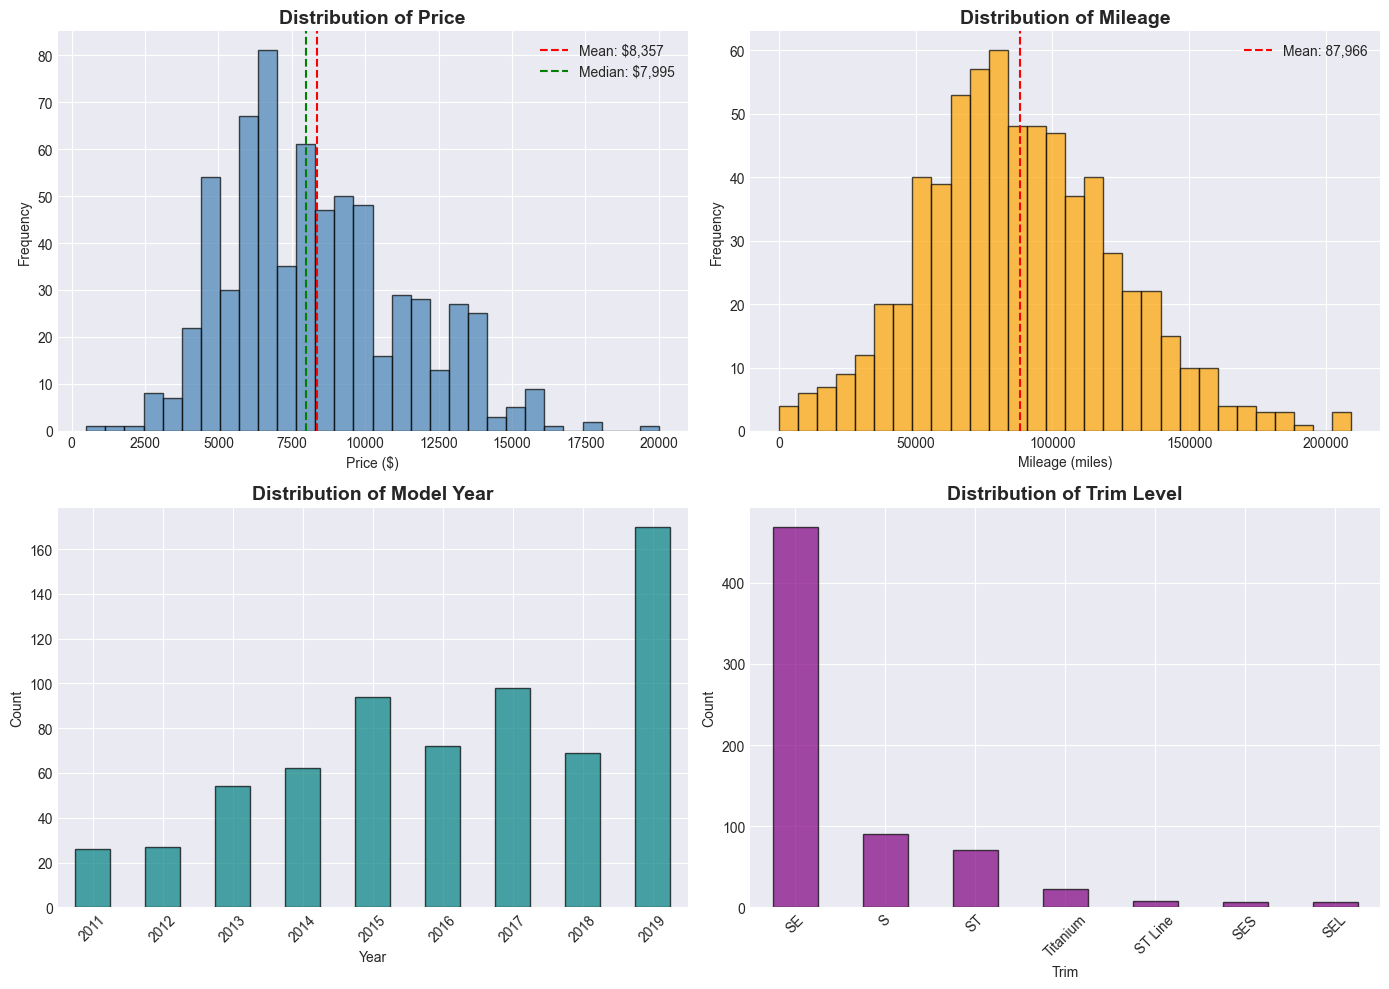

In [64]:
# Create subplots for distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
axes[0, 0].hist(df['price'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Distribution of Price', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: ${df["price"].mean():,.0f}')
axes[0, 0].axvline(df['price'].median(), color='green', linestyle='--', label=f'Median: ${df["price"].median():,.0f}')
axes[0, 0].legend()

# Mileage distribution
axes[0, 1].hist(df['mileage'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Distribution of Mileage', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mileage (miles)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['mileage'].mean(), color='red', linestyle='--', label=f'Mean: {df["mileage"].mean():,.0f}')
axes[0, 1].legend()

# Year distribution
year_counts.plot(kind='bar', ax=axes[1, 0], color='teal', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Model Year', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Trim distribution
trim_counts.plot(kind='bar', ax=axes[1, 1], color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of Trim Level', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Trim')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('distributions.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Price vs. Mileage Relationship

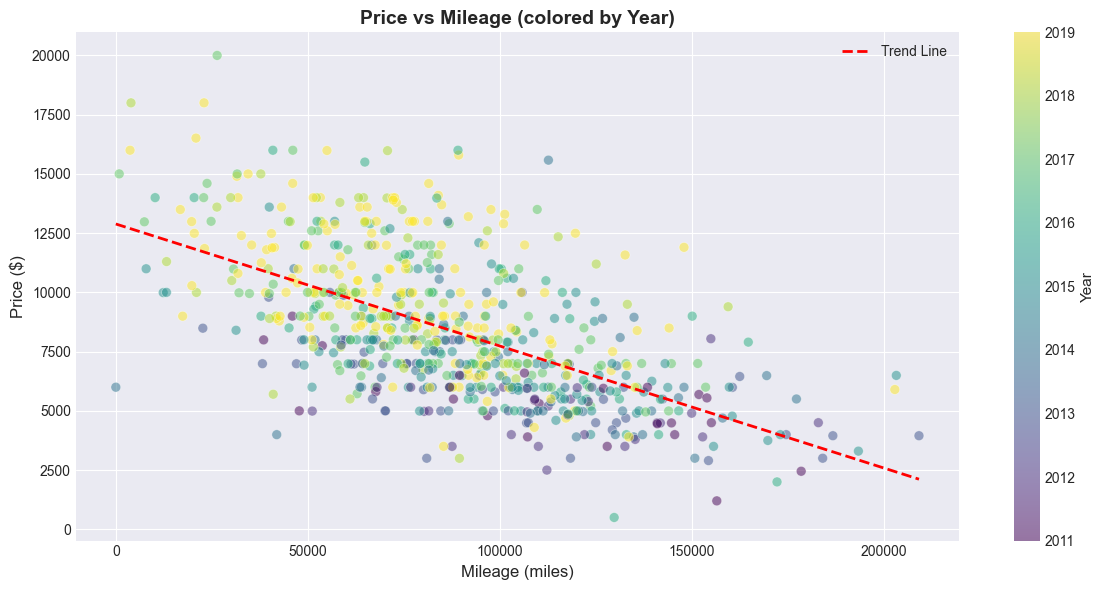

In [65]:
# Scatter plot: Price vs Mileage
fig, ax = plt.subplots(figsize=(12, 6))

scatter = ax.scatter(df['mileage'], df['price'], alpha=0.5, c=df['year'], 
                     cmap='viridis', s=50, edgecolor='white', linewidth=0.5)
ax.set_xlabel('Mileage (miles)', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('Price vs Mileage (colored by Year)', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Year', fontsize=11)

# Add trend line
z = np.polyfit(df['mileage'], df['price'], 1)
p = np.poly1d(z)
mileage_range = np.linspace(df['mileage'].min(), df['mileage'].max(), 100)
ax.plot(mileage_range, p(mileage_range), 'r--', linewidth=2, label='Trend Line')
ax.legend()

plt.tight_layout()
plt.savefig('price_vs_mileage.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Price by Trim Level

/var/folders/hs/9b2qhy691rq93qc68k0k5lk40000gn/T/ipykernel_18292/2445079449.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='trim', y='price', order=trim_order, ax=ax, palette='viridis')


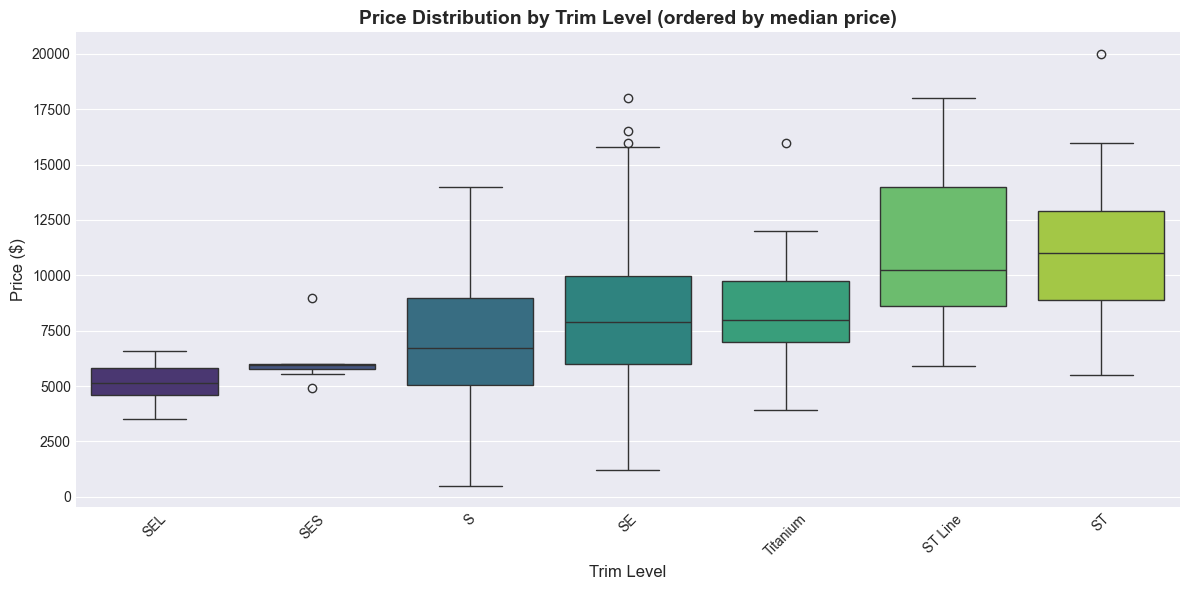

In [66]:
# Box plot: Price by Trim
fig, ax = plt.subplots(figsize=(12, 6))

# Order trims by median price
trim_order = df.groupby('trim')['price'].median().sort_values().index

sns.boxplot(data=df, x='trim', y='price', order=trim_order, ax=ax, palette='viridis')
ax.set_xlabel('Trim Level', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('Price Distribution by Trim Level (ordered by median price)', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('price_by_trim.png', dpi=150, bbox_inches='tight')
plt.show()

In [67]:
# Summary statistics by trim
print("Price Statistics by Trim Level:")
print("=" * 60)
trim_stats = df.groupby('trim')['price'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
trim_stats = trim_stats.round(2).sort_values('median', ascending=False)
trim_stats

Price Statistics by Trim Level:


,count,mean,median,std,min,max
trim,,,,,,
ST,70,11010.31,10992.5,2829.32,5500,19999
ST Line,8,11108.25,10238.5,3989.14,5900,17999
Titanium,22,8463.00,7995.0,2641.92,3900,15998
SE,469,8208.94,7900.0,2901.93,1200,17998
S,90,7177.40,6722.5,2619.73,499,13998
SES,7,6191.00,5951.0,1300.55,4900,8997
SEL,6,5147.33,5152.0,1096.08,3500,6595


### 6.4 Price by Year

/var/folders/hs/9b2qhy691rq93qc68k0k5lk40000gn/T/ipykernel_18292/1128054132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='year', y='price', ax=ax, palette='coolwarm')


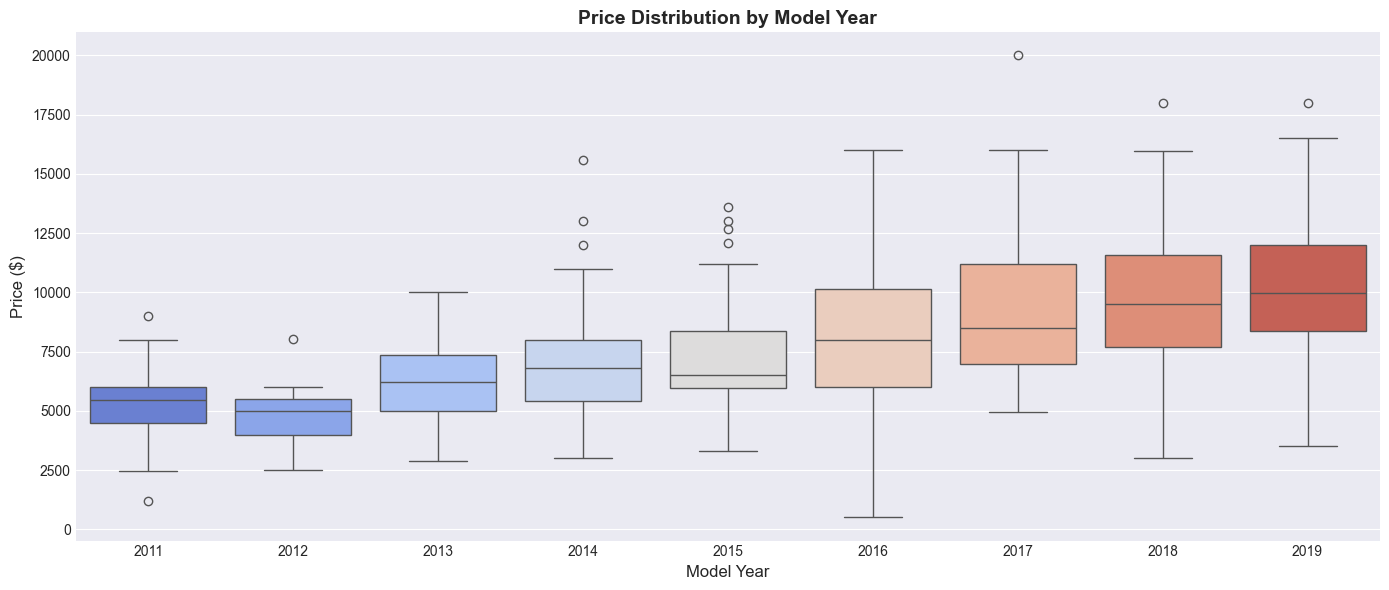

In [68]:
# Box plot: Price by Year
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(data=df, x='year', y='price', ax=ax, palette='coolwarm')
ax.set_xlabel('Model Year', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('Price Distribution by Model Year', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('price_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

In [69]:
# Summary statistics by year
print("Price Statistics by Year:")
print("=" * 60)
year_stats = df.groupby('year')['price'].agg(['count', 'mean', 'median']).round(2)
year_stats

Price Statistics by Year:


,count,mean,median
year,,,
2011,26,5391.88,5474.0
2012,27,4870.85,4977.0
2013,54,6238.28,6222.5
2014,62,7073.29,6810.0
2015,94,7200.89,6499.5
2016,72,8366.36,7992.5
2017,98,9210.55,8500.0
2018,69,9811.74,9495.0
2019,170,10058.44,9988.5


### 6.5 Correlation Analysis

In [70]:
# Correlation matrix for numeric variables
numeric_cols = ['price', 'mileage', 'year', 'distance']
correlation_matrix = df[numeric_cols].corr()

print("Correlation Matrix:")
print("=" * 60)
print(correlation_matrix.round(3))

Correlation Matrix:
          price  mileage   year  distance
price     1.000   -0.601  0.523    -0.091
mileage  -0.601    1.000 -0.339    -0.006
year      0.523   -0.339  1.000    -0.042
distance -0.091   -0.006 -0.042     1.000


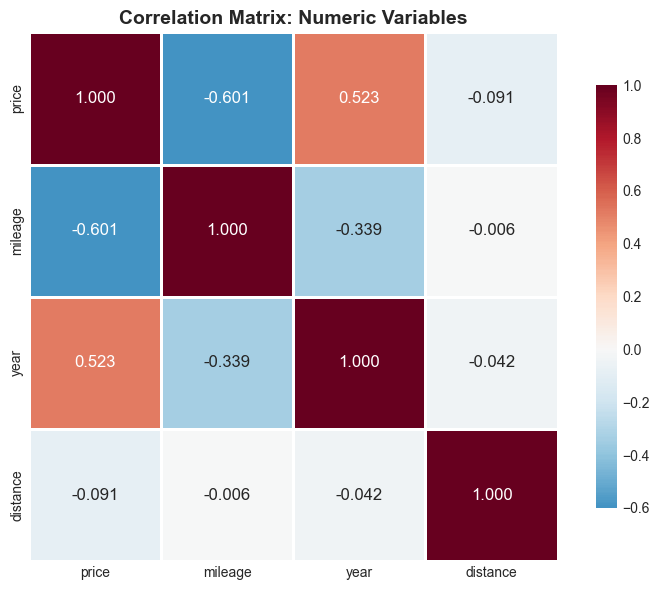

In [71]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', annot_kws={'size': 12})
ax.set_title('Correlation Matrix: Numeric Variables', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.6 Geographic Distribution

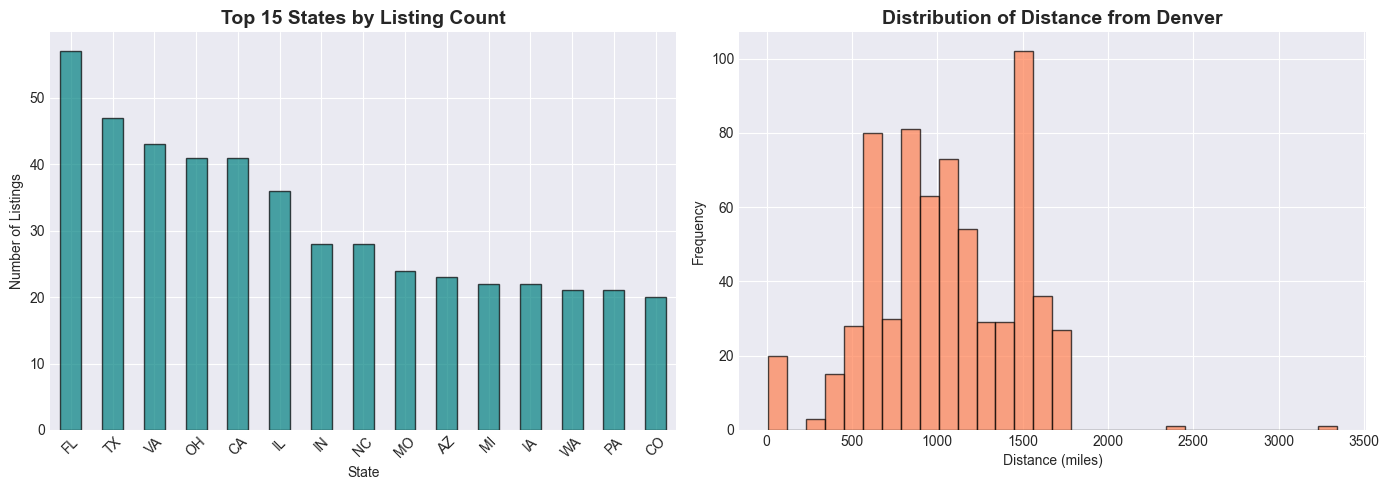

In [72]:
# Top 15 states by listing count
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# State counts
state_counts.head(15).plot(kind='bar', ax=axes[0], color='teal', edgecolor='black', alpha=0.7)
axes[0].set_title('Top 15 States by Listing Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Number of Listings')
axes[0].tick_params(axis='x', rotation=45)

# Distance distribution
axes[1].hist(df['distance'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title('Distribution of Distance from Denver', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Distance (miles)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('geographic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.7 Multi-Variable Relationships

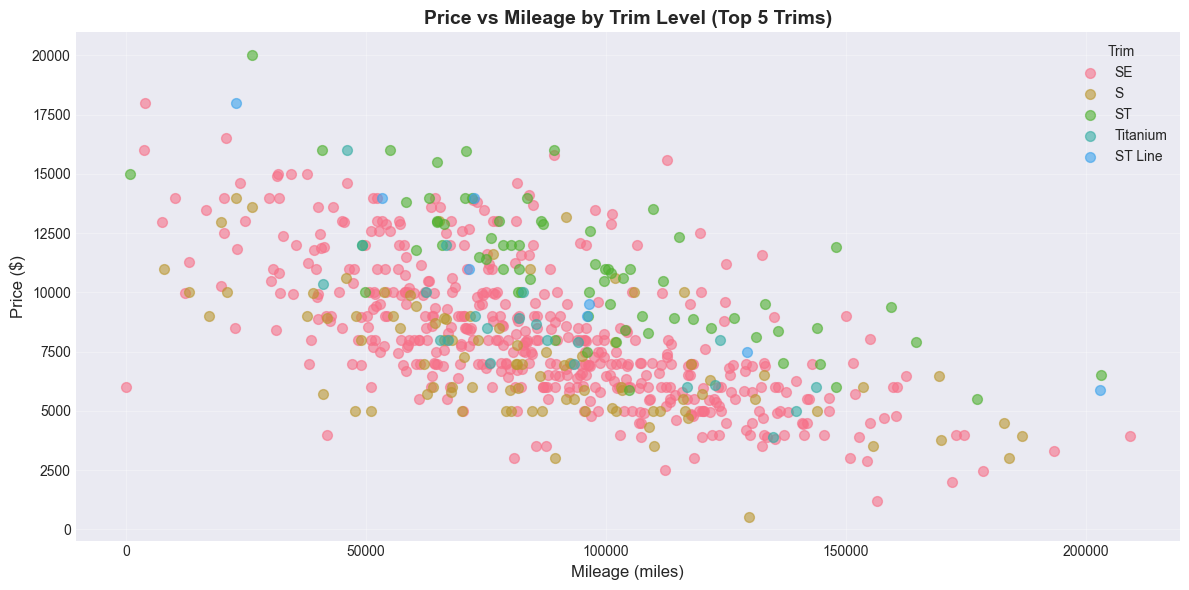

In [73]:
# Price vs Mileage by Trim (for most common trims)
top_trims = trim_counts.head(5).index.tolist()
df_top_trims = df[df['trim'].isin(top_trims)]

fig, ax = plt.subplots(figsize=(12, 6))

for trim in top_trims:
    trim_data = df_top_trims[df_top_trims['trim'] == trim]
    ax.scatter(trim_data['mileage'], trim_data['price'], alpha=0.6, label=trim, s=50)

ax.set_xlabel('Mileage (miles)', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('Price vs Mileage by Trim Level (Top 5 Trims)', fontsize=14, fontweight='bold')
ax.legend(title='Trim')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('price_mileage_by_trim.png', dpi=150, bbox_inches='tight')
plt.show()

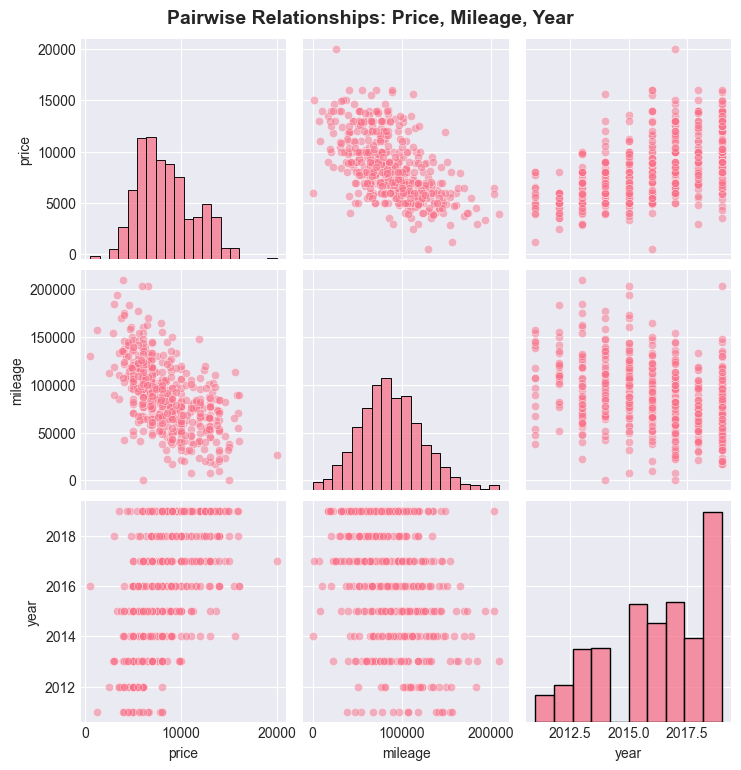

In [74]:
# Pairplot for key numeric variables (sampled for performance)
df_sample = df.sample(min(500, len(df)), random_state=42)

g = sns.pairplot(df_sample[['price', 'mileage', 'year']], 
                 diag_kind='hist', plot_kws={'alpha': 0.5})
g.fig.suptitle('Pairwise Relationships: Price, Mileage, Year', y=1.02, fontsize=14, fontweight='bold')

plt.savefig('pairplot.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Key Insights and Findings

### 7.1 Dataset Overview

In [75]:
print("=" * 70)
print("KEY INSIGHTS SUMMARY")
print("=" * 70)

print("\n📊 DATASET CHARACTERISTICS:")
print(f"   • Total listings analyzed: {len(df):,}")
print(f"   • Listings removed (no price): {len(df_raw) - len(df):,} ({(len(df_raw) - len(df))/len(df_raw)*100:.1f}%)")
print(f"   • Year range: {df['year'].min()} to {df['year'].max()}")
print(f"   • Geographic coverage: {df['state'].nunique()} states")
print(f"   • Trim levels: {df['trim'].nunique()} unique trims")

KEY INSIGHTS SUMMARY

📊 DATASET CHARACTERISTICS:
   • Total listings analyzed: 672
   • Listings removed (no price): 25 (3.6%)
   • Year range: 2011 to 2019
   • Geographic coverage: 44 states
   • Trim levels: 7 unique trims


In [76]:
print("\n💰 PRICE INSIGHTS:")
print(f"   • Price range: ${df['price'].min():,} to ${df['price'].max():,}")
print(f"   • Mean price: ${df['price'].mean():,.2f}")
print(f"   • Median price: ${df['price'].median():,.2f}")
print(f"   • Standard deviation: ${df['price'].std():,.2f}")

# Price skewness
skewness = df['price'].skew()
print(f"   • Distribution skewness: {skewness:.2f} ({'right-skewed' if skewness > 0 else 'left-skewed'})")


💰 PRICE INSIGHTS:
   • Price range: $499 to $19,999
   • Mean price: $8,357.07
   • Median price: $7,995.00
   • Standard deviation: $3,030.44
   • Distribution skewness: 0.57 (right-skewed)


In [77]:
print("\n🚗 MILEAGE INSIGHTS:")
print(f"   • Mileage range: {df['mileage'].min():,} to {df['mileage'].max():,} miles")
print(f"   • Mean mileage: {df['mileage'].mean():,.0f} miles")
print(f"   • Median mileage: {df['mileage'].median():,.0f} miles")

# Correlation with price
price_mileage_corr = df['price'].corr(df['mileage'])
print(f"   • Correlation with price: {price_mileage_corr:.3f} (moderate negative)")


🚗 MILEAGE INSIGHTS:
   • Mileage range: 0 to 209,211 miles
   • Mean mileage: 87,966 miles
   • Median mileage: 84,842 miles
   • Correlation with price: -0.601 (moderate negative)


In [78]:
print("\n📍 TRIM LEVEL INSIGHTS:")
most_common_trim = df['trim'].mode()[0]
most_expensive_trim = df.groupby('trim')['price'].median().idxmax()
least_expensive_trim = df.groupby('trim')['price'].median().idxmin()

print(f"   • Most common trim: {most_common_trim} ({(df['trim'] == most_common_trim).sum()} listings)")
print(f"   • Highest median price: {most_expensive_trim} (${df.groupby('trim')['price'].median().max():,.0f})")
print(f"   • Lowest median price: {least_expensive_trim} (${df.groupby('trim')['price'].median().min():,.0f})")


📍 TRIM LEVEL INSIGHTS:
   • Most common trim: SE (469 listings)
   • Highest median price: ST ($10,992)
   • Lowest median price: SEL ($5,152)


In [79]:
print("\n📅 YEAR INSIGHTS:")
year_price_corr = df['price'].corr(df['year'])
print(f"   • Correlation with price: {year_price_corr:.3f} (strong positive)")
print(f"   • Most common year: {df['year'].mode()[0]} ({(df['year'] == df['year'].mode()[0]).sum()} listings)")

print("\n🗺️ GEOGRAPHIC INSIGHTS:")
top_state = df['state'].mode()[0]
print(f"   • Most listings: {top_state} ({(df['state'] == top_state).sum()} listings)")
print(f"   • Average distance from Denver: {df['distance'].mean():,.0f} miles")


📅 YEAR INSIGHTS:
   • Correlation with price: 0.523 (strong positive)
   • Most common year: 2019 (170 listings)

🗺️ GEOGRAPHIC INSIGHTS:
   • Most listings: FL (57 listings)
   • Average distance from Denver: 1,046 miles


### 7.2 Key Findings for Modeling

In [ ]:
print("\n" + "=" * 70)
print("IMPLICATIONS FOR PRICE PREDICTION MODELING")
print("=" * 70)

print("""
1. MILEAGE is a strong predictor:
   - Negative correlation with price ({:.3f})
   - As expected, higher mileage = lower price
   - Should be included as a primary feature

2. YEAR is an important predictor:
   - Strong positive correlation with price ({:.3f})
   - Newer cars command higher prices
   - Should be included as a primary feature

3. TRIM LEVEL significantly affects price:
   - ST trim commands the highest premiums (performance variant)
   - S trim (base model) has lowest prices
   - Requires one-hot encoding for linear models

4. DISTANCE from Denver shows minimal correlation ({:.3f}):
   - Geographic location has limited impact on pricing
   - May still be worth including but lower priority

5. DATA QUALITY:
   - No missing values in cleaned dataset
   - {} listings with "Not Priced" were removed
   - Dataset is clean and ready for modeling

6. FEATURE ENGINEERING CONSIDERATIONS:
   - 7 trim levels & 44 states to one-hot encode
""".format(
    price_mileage_corr,
    year_price_corr,
    df['price'].corr(df['distance']),
    len(df_raw) - len(df),
))


IMPLICATIONS FOR PRICE PREDICTION MODELING

1. MILEAGE is a strong predictor:
   - Negative correlation with price (-0.601)
   - As expected, higher mileage = lower price
   - Should be included as a primary feature

2. YEAR is an important predictor:
   - Strong positive correlation with price (0.523)
   - Newer cars command higher prices
   - Should be included as a primary feature

3. TRIM LEVEL significantly affects price:
   - ST trim commands the highest premiums (performance variant)
   - S trim (base model) has lowest prices
   - Requires one-hot encoding for linear models

4. DISTANCE from Denver shows minimal correlation (-0.091):
   - Geographic location has limited impact on pricing
   - May still be worth including but lower priority

5. DATA QUALITY:
   - No missing values in cleaned dataset
   - 25 listings with "Not Priced" were removed
   - Dataset is clean and ready for modeling

6. FEATURE ENGINEERING CONSIDERATIONS:
   - Categorical variables (trim, state) need enc

---
## 8. Data Export

Save the cleaned and processed dataset for use in modeling.

In [81]:
# Save processed dataset
df.to_csv('ford_fiestas_extrap.csv', index=False)
print("✅ Processed data saved to 'ford_fiestas_extrap.csv'")
print(f"   Shape: {df.shape[0]} rows × {df.shape[1]} columns")

✅ Processed data saved to 'ford_fiestas_extrap.csv'
   Shape: 672 rows × 8 columns


In [82]:
# Create one-hot encoded version for modeling
df_encoded = df.copy()

# One-hot encode states
state_dummies = pd.get_dummies(df_encoded['state'], prefix='state')
df_encoded = pd.concat([df_encoded, state_dummies], axis=1)

# One-hot encode trims
trim_dummies = pd.get_dummies(df_encoded['trim'], prefix='trim')
df_encoded = pd.concat([df_encoded, trim_dummies], axis=1)

# Save one-hot encoded version
df_encoded.to_csv('ford_fiestas_extrap_one_hot.csv', index=False)
print("\n✅ One-hot encoded data saved to 'ford_fiestas_extrap_one_hot.csv'")
print(f"   Shape: {df_encoded.shape[0]} rows × {df_encoded.shape[1]} columns")
print(f"   State features: {len(state_dummies.columns)}")
print(f"   Trim features: {len(trim_dummies.columns)}")


✅ One-hot encoded data saved to 'ford_fiestas_extrap_one_hot.csv'
   Shape: 672 rows × 59 columns
   State features: 44
   Trim features: 7


---
## 9. Summary

This EDA notebook has accomplished the following:

**Data Cleaning:**
- Loaded 697 raw listings scraped from Cars.com
- Removed listings without valid prices
- Manually consolidated trim levels and removed outliers (e.g., zero-mileage listings)
- Final clean dataset: 671 listings

**Feature Engineering:**
- Extracted year and trim from title strings
- Consolidated 19 raw trim variations into 7 standard trim levels (S, SE, SEL, SES, ST, ST Line, Titanium)
- Converted price and mileage from formatted strings to numeric values
- Extracted state and distance from location strings
- Created one-hot encoded features for categorical variables

**Key Discoveries:**
- Strong negative correlation between mileage and price
- Strong positive correlation between year and price
- Significant price variation across trim levels (ST commands premium)
- Minimal impact of geographic distance on pricing

**Data Ready for Modeling:**
- `ford_fiestas_extrap.csv`: Cleaned data with extracted features
- `ford_fiestas_extrap_one_hot.csv`: Data with one-hot encoded categorical variables

The next step is to build predictive models in a separate notebook to forecast Ford Fiesta prices based on these features.